# LocaleDB: Multivariate Time Series Clustering (Performance Evaluation)
---

This notebook focuses on multivariate time series (MVTS) clustering performance evaluation.  The time series in question are Covid-19 disease dynamics (specifically daily counts of confirmed cases and deaths in US counties).

## Environment
---

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import scipy.signal
import sklearn
import time

from datetime import timedelta

from localedb.localedb import LocaleDB
from localedb.clustering import cluster_aff_prop, cluster_kmeans, cluster_kmedoids, cluster_kshape, cluster_optics, cluster_spectral
from localedb.clustering import dist_mat
from localedb.clustering import plot_cluster_perf_eval_heatmap, plot_cluster_perf_eval_heatmap_split

db = LocaleDB().set_disease('COVID-19')

First, we declare variables and convenience functions:

In [3]:
dis_dyn = ['n_conf', 'n_dead']  # disease dynamics time series

## Data
---

### Simulated dynamics: Epidemic in schools

The first dataset we use is based on a simulation of Covid-19 epidemic in schools of the Allegheny County, PA.

In [4]:
def get_data_ac_schools():
    with open(os.path.join('data', 'ac_schools.json')) as f:
        a = json.load(f)
    for k in ['raw', 'std', 'diff', 'std-diff']:
        a[k] = [np.asarray(j) for j in a[k]]
    return a

ds_ac_schools = get_data_ac_schools()

To evaluate clustering performance we need true labels, i.e., the labels which would represent the actual clusters items would get assigned to.  Here are those labels for the current dataset:

In [5]:
for (i,j) in enumerate(ds_ac_schools['labels']):
    print(f'{i}: {j}')
del(i,j)

0: [0, 1, 2, 3]
1: [0, 0, 1, 1, 2, 2, 3, 3]
2: [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


### Observed dynamics: Covid-19 in US counties

The second dataset we use comprizes the observed multivariate Covid-19 disease dynamics in four US states: Pennsylvania, New York, California, and Florida.  In this notebook, we evaluate both the standardized and standardized differenced disease dynamics and therefore in the cell below we create both kinds of datasets for each of the states.

In [6]:
def get_data_c19(fips='42___', cols=dis_dyn, day0=0, day1=99999, do_interpolate=True, n_diff=0, smooth_window_len=14):
    return np.array(db.get_dis_dyn_by_fips(fips, cols, day0, day1, do_interpolate, n_diff, smooth_window_len, do_scale=True)[0])

ds_pa   = get_data_c19('42___', n_diff=0, smooth_window_len=14)  # standardized
ds_ny   = get_data_c19('36___', n_diff=0, smooth_window_len=14)
ds_ca   = get_data_c19('06___', n_diff=0, smooth_window_len=14)
ds_fl   = get_data_c19('12___', n_diff=0, smooth_window_len=14)

ds_pa_d = get_data_c19('42___', n_diff=1, smooth_window_len=28)  # standardized differenced
ds_ny_d = get_data_c19('36___', n_diff=1, smooth_window_len=28)
ds_ca_d = get_data_c19('06___', n_diff=1, smooth_window_len=28)
ds_fl_d = get_data_c19('12___', n_diff=1, smooth_window_len=28)

Naturally, we need true labels.  The problem is, we do not have such labels.  If we knew how to group the counties by disease dynamics, we wouldn't be doing clustering to begin with.  To sidestep this problem, we will assume that the size of population and the proportion of flu vaxinations in a county, both discretized into four bins, will provide us with our true labels.  The reasoning behind this is simple: It is likely that the spread of the virus correlated with the size of a county's population and the willingess of that population to get flu vaccines.  First, we load the population size data from the database.

In [7]:
ds_pa_pop = np.array([r[0] for r in db._exec('SELECT pop FROM main.locale WHERE fips LIKE %s ORDER BY fips ASC;', ['42___'])], np.int32)
ds_ny_pop = np.array([r[0] for r in db._exec('SELECT pop FROM main.locale WHERE fips LIKE %s ORDER BY fips ASC;', ['36___'])], np.int32)
ds_ca_pop = np.array([r[0] for r in db._exec('SELECT pop FROM main.locale WHERE fips LIKE %s ORDER BY fips ASC;', ['06___'])], np.int32)
ds_fl_pop = np.array([r[0] for r in db._exec('SELECT pop FROM main.locale WHERE fips LIKE %s ORDER BY fips ASC;', ['12___'])], np.int32)

Next, we define the population-size based true labels:

In [8]:
ds_pa_labels_pop = sklearn.preprocessing.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans').fit_transform(ds_pa_pop.reshape((-1,1))).reshape(-1).astype(np.int32)
ds_ny_labels_pop = sklearn.preprocessing.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans').fit_transform(ds_ny_pop.reshape((-1,1))).reshape(-1).astype(np.int32)
ds_ca_labels_pop = sklearn.preprocessing.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans').fit_transform(ds_ca_pop.reshape((-1,1))).reshape(-1).astype(np.int32)
ds_fl_labels_pop = sklearn.preprocessing.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans').fit_transform(ds_fl_pop.reshape((-1,1))).reshape(-1).astype(np.int32)

Finally, we define the flu-vaccination-ratio based true labels:

In [9]:
def get_fips_stat(fips='42___', lbl_n_bins=4, cols=['n_conf', 'n_dead'], day0=0, day1=99999, do_interpolate=True, n_diff=1, smooth_window_len=14, var='flu_vax'):
    a = np.array(db.get_dis_dyn_by_fips(fips, cols, day0, day1, do_interpolate, n_diff, smooth_window_len, do_scale=True)[0])
    v = np.array(db.get_health_stats_by_fips(fips, get_pandas=True)[var].tolist())
    a = a[np.nonzero(v.tolist())]
    v = v[v != np.array(None)]
    l = sklearn.preprocessing.KBinsDiscretizer(lbl_n_bins, encode='ordinal', strategy='kmeans').fit_transform(v.reshape((len(v), 1))).reshape((len(v))).astype(np.int32)
    return (a,l)

In [10]:
ds_pa_labels_flu_vax = get_fips_stat('42___', 4, var='flu_vax')[1]
ds_ny_labels_flu_vax = get_fips_stat('36___', 4, var='flu_vax')[1]
ds_ca_labels_flu_vax = get_fips_stat('06___', 4, var='flu_vax')[1]
ds_fl_labels_flu_vax = get_fips_stat('12___', 4, var='flu_vax')[1]

Of course, we will use either of these two sets of true labels separately and at this point we don't know which one the clustering results will be closer to.

## Clustering Performance Evaluation
---

### Prepare experiments

We will evaluate clustering performance with respect to several metrics which we define below (for information on those and other metrics, see, e.g., [scikit-learn docs](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)):

In [11]:
cluster_perf_metrics = {
    'homo' : sklearn.metrics.homogeneity_score,
    'comp' : sklearn.metrics.completeness_score,
    'v'    : sklearn.metrics.v_measure_score,
    'ri'   : sklearn.metrics.rand_score,
    'ari'  : sklearn.metrics.adjusted_rand_score,
    'mi'   : sklearn.metrics.mutual_info_score,
    'ami'  : sklearn.metrics.adjusted_mutual_info_score,
    'fm'   : sklearn.metrics.fowlkes_mallows_score,
    'sc'   : lambda dm, l: sklearn.metrics.silhouette_score(dm, l, metric='precomputed')
}

We will cluster and subsequently evaluate the performance of the following algorithms divided into two categories:

- With number of clusters:
   - [Affinity propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html)
   - [K-Means](https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html)
   - [K-Medoids](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html)
   - [K-Shape](https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.KShape.html)
- Without number of clusters:
   - [OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) (with multiple combinations of argument values)
   - [Spectral](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

We will devide the clustering and the evaluation into two categories as well.  The two functions we define below cluster and evaluate with and without the number of clusters, respectively.  Clustering results are evaluated based on the true labels which we have defined earlier.  Several multivariate time series distance measures (e.g., Euclidean, Dynamic Time Warping, and Continuous Wavelet Transform based) are used as input to (or, where applicable, a part of) the clustering algorithms under investigation.

In [12]:
def cluster_perf_eval_k(a,l,k, metrics=cluster_perf_metrics, dm=None, random_state=None, **kwargs):
    """Evaluates clustering performance on the dataset specified with algorithms that take the number of clusters as a parameter.
    
    Args:
        a: Dataset.
        l: True labels.
        k: Number of clusters.
        metrics (Mapping): Performance evaluation metrics.
        dm (ndarray): Distance matrix.  Computed if ``None``.
        random_state (int): Pseudo-random number generator state.
    
    Returns:
        (Mapping, Mapping): A tuple containing the performance and prediction dictionaries.
    """
    
    algorithms = [
        { 'name': 'kmediods', 'fn': lambda dm,k: cluster_kmedoids(dm, k, 'precomputed') },
        { 'name': 'spectral', 'fn': cluster_spectral }
    ]
    
    perf = { i: {} for i in metrics.keys() }
    pred = {}
    
    # (1) Compute distance matrices:
    if dm is None:
        dm = {
            'euc'           : dist_mat(a, metric='euclidean'),
            'corr'          : dist_mat(a, metric='correlation'),
            'dtw'           : dist_mat(a, metric='dtw'),
            'cwt-spca-cmor' : dist_mat(a, metric='cwt-spca', wavelet='cmor')  # Imaginary domain; not used for clustering
        }
        dm['cwt-spca-cmor-real'] = np.real(dm['cwt-spca-cmor'])
    
    # (2) Cluster:
    # (2.1) K-Means + K-Shape:
    pred['kmeans-euc'] = { 'labels': cluster_kmeans(a, k, 'euclidean', random_state=random_state).labels_, 'dist-measure': None }
    pred['kmeans-dtw'] = { 'labels': cluster_kmeans(a, k, 'dtw',       random_state=random_state).labels_, 'dist-measure': None }
    pred['kshape']     = { 'labels': cluster_kshape(a, k,              random_state=random_state).labels_, 'dist-measure': None }
    
    # (2.2) Other algorithms:
    for alg in algorithms:
        for (dk,dv) in dm.items():
            if dk == 'cwt-spca-cmor':
                continue
            alg_l = alg['fn'](dv, k, **kwargs).labels_
            pred[f'{alg["name"]}-{dk}'] = { 'labels': alg_l, 'k': np.unique(alg_l).shape[0], 'dist-measure': dk }
    
    # (3) Evaluate:
    for (m_name, m_fn) in metrics.items():
        for (p_name, p) in pred.items():
            if m_name in ['sc']:
                if p['dist-measure'] is None or len(np.unique(p['labels'])) == 1 or len(np.unique(p['labels'])) >= dm[p['dist-measure']].shape[0]:
                    perf[m_name][p_name] = 0.0
                else:
                    perf[m_name][p_name] = m_fn(dm[p['dist-measure']], p['labels'])
            else:
                perf[m_name][p_name] = m_fn(l, p['labels'])
    
    return (perf, pred)

In [13]:
def cluster_perf_eval_no_k(a,l, metrics=cluster_perf_metrics, dm=None, random_state=None, **kwargs):
    """Evaluates clustering performance on the dataset specified with algorithms that do not take the number of clusters as a parameter.
    
    Args:
        a: Dataset.
        l: True labels.
        metrics (Mapping): Performance evaluation metrics.
        dm (ndarray): Distance matrix.  Computed if ``None``.
        random_state (int): Pseudo-random number generator state.
    
    Returns:
        (Mapping, Mapping): A tuple containing the performance and prediction dictionaries.
    """
    
    algorithms = [
        { 'name': 'optics-0.1-3',  'fn': lambda dm, **kwargs: cluster_optics(dm, cluster_method='xi', xi=0.1,  min_samples=3, **kwargs) },
        { 'name': 'optics-0.01-3', 'fn': lambda dm, **kwargs: cluster_optics(dm, cluster_method='xi', xi=0.01, min_samples=3, **kwargs) },
        { 'name': 'optics-0.1-2',  'fn': lambda dm, **kwargs: cluster_optics(dm, cluster_method='xi', xi=0.1,  min_samples=2, **kwargs) },
        { 'name': 'optics-0.01-2', 'fn': lambda dm, **kwargs: cluster_optics(dm, cluster_method='xi', xi=0.01, min_samples=2, **kwargs) },
        { 'name': 'aff-prop',      'fn': cluster_aff_prop }
    ]
    
    perf = { i: {} for i in metrics.keys() }  # clustering performance
    pred = {}
    
    # (1) Compute distance matrices:
    if dm is None:
        dm = {
            'euc'           : dist_mat(a, metric='euclidean'),
            'corr'          : dist_mat(a, metric='correlation'),
            'dtw'           : dist_mat(a, metric='dtw'),
            'cwt-spca-cmor' : dist_mat(a, metric='cwt-spca', wavelet='cmor')  # Imaginary domain; not used for clustering directly (transformed to Real domain below)
        }
        dm['cwt-spca-cmor-real'] = np.real(dm['cwt-spca-cmor'])
    
    # (2) Cluster:
    for alg in algorithms:
        for (dk,dv) in dm.items():
            if dk == 'cwt-spca-cmor':
                continue
            alg_l = alg['fn'](dv, **kwargs).labels_
            pred[f'{alg["name"]}-{dk}'] = { 'labels': alg_l, 'k': np.unique(alg_l).shape[0], 'dist-measure': dk }
    
    # (3) Evaluate:
    for (m_name, m_fn) in metrics.items():
        for (p_name, p) in pred.items():
            if m_name in ['sc']:
                if p['dist-measure'] is None or len(np.unique(p['labels'])) == 1 or len(np.unique(p['labels'])) >= dm[p['dist-measure']].shape[0]:
                    perf[m_name][p_name] = 0.0
                else:
                    perf[m_name][p_name] = m_fn(dm[p['dist-measure']], p['labels'])
            else:
                perf[m_name][p_name] = m_fn(l, p['labels'])
    
    return (perf, pred)

The following function performs a call dispatch to either of the two "work" functions above:

In [14]:
def cluster_perf_eval(a,l,k=None, random_state=None, **kwargs):
    if k is None:
        return cluster_perf_eval_no_k(a,l, random_state, **kwargs)
    else:
        return cluster_perf_eval_k(a,l,k, random_state, **kwargs)

The function below is where we set up our evaluation experiments.  We specify which datasets we will evaluate the algorithms on and which true labels will be used for each evaluation.  There is no need to specify the algorithms and metrics because we have already done that earlier.  We will be calling this function in a verbose mode to track progress as computations can take a few minutes per dataset.

In [15]:
def cluster_perf_eval_all_ds(res_dict, with_k=True, random_state=None, item_names=['ac_schools', 'pa', 'ny', 'ca', 'fl'], is_verbose=False, **kwargs):
    """Evaluates clustering performance on all datasets.
    
    A dataset is evaluated only if it has not been evaluated yet.  That is, to force a dataset to be evaluated, it needs to not exist
    in ``res_dict``.  Check the ``items`` dictionary in the function's body for more details.
    
    Args:
        res_dict (Mapping): The results dictionary.  This dicrionary is updated with the evaluation results.
        with_k (boolean): With or without the number of clusters?
        random_state (int): Pseudo-random number generator state.
        item_names (Iterable(str)): Datasets to run.  Check the ``items`` dictionary in the function's body for more details.
        is_verbose (boolean): Print progress?
    """
    
    items = {}
    
    if 'ac_schools' in item_names:
        items = dict(items, **{
            'ds_ac_schools_1': [ds_ac_schools['std'][1], ds_ac_schools['labels'][1], len(ds_ac_schools['labels'][1]), 'ac.schools.1'],
            'ds_ac_schools_2': [ds_ac_schools['std'][2], ds_ac_schools['labels'][2], len(ds_ac_schools['labels'][2]), 'ac.schools.2'],
            'ds_ac_schools_3': [ds_ac_schools['std'][3], ds_ac_schools['labels'][3], len(ds_ac_schools['labels'][3]), 'ac.schools.3']
        })
    
    if 'pa' in item_names:
        items = dict(items, **{
            'ds_pa_pop':       [ds_pa,   ds_pa_labels_pop,     len(np.unique(ds_pa_labels_pop)),     'pa.pop'],
            'ds_pa_flu_vax':   [ds_pa,   ds_pa_labels_flu_vax, len(np.unique(ds_pa_labels_flu_vax)), 'pa.flu_vax'],
            'ds_pa_pop_d':     [ds_pa_d, ds_pa_labels_pop,     len(np.unique(ds_pa_labels_pop)),     'pa.pop.d'],
            'ds_pa_flu_vax_d': [ds_pa_d, ds_pa_labels_flu_vax, len(np.unique(ds_pa_labels_flu_vax)), 'pa.flu_vax.d']
        })
    
    if 'ny' in item_names:
        items = dict(items, **{
            'ds_ny_pop':       [ds_ny,   ds_ny_labels_pop,     len(np.unique(ds_ny_labels_pop)),     'ny.pop'],
            'ds_ny_flu_vax':   [ds_ny,   ds_ny_labels_flu_vax, len(np.unique(ds_ny_labels_flu_vax)), 'ny.flu_vax'],
            'ds_ny_pop_d':     [ds_ny_d, ds_ny_labels_pop,     len(np.unique(ds_ny_labels_pop)),     'ny.pop.d'],
            'ds_ny_flu_vax_d': [ds_ny_d, ds_ny_labels_flu_vax, len(np.unique(ds_ny_labels_flu_vax)), 'ny.flu_vax.d']
        })
    
    if 'ca' in item_names:
        items = dict(items, **{
            'ds_ca_pop':       [ds_ca,   ds_ca_labels_pop,     len(np.unique(ds_ca_labels_pop)),     'ca.pop'],
            'ds_ca_flu_vax':   [ds_ca,   ds_ca_labels_flu_vax, len(np.unique(ds_ca_labels_flu_vax)), 'ca.flu_vax'],
            'ds_ca_pop_d':     [ds_ca_d, ds_ca_labels_pop,     len(np.unique(ds_ca_labels_pop)),     'ca.pop.d'],
            'ds_ca_flu_vax_d': [ds_ca_d, ds_ca_labels_flu_vax, len(np.unique(ds_ca_labels_flu_vax)), 'ca.flu_vax.d']
        })
    
    if 'fl' in item_names:
        items = dict(items, **{
            'ds_fl_pop':       [ds_fl,   ds_fl_labels_pop,     len(np.unique(ds_fl_labels_pop)),     'fl.pop'],
            'ds_fl_flu_vax':   [ds_fl,   ds_fl_labels_flu_vax, len(np.unique(ds_fl_labels_flu_vax)), 'fl.flu_vax'],
            'ds_fl_pop_d':     [ds_fl_d, ds_fl_labels_pop,     len(np.unique(ds_fl_labels_pop)),     'fl.pop.d'],
            'ds_fl_flu_vax_d': [ds_fl_d, ds_fl_labels_flu_vax, len(np.unique(ds_fl_labels_flu_vax)), 'fl.flu_vax.d']
        })
    
    if is_verbose:
        print('Dataset                           t\n-------------  --------------------')
    for (k,v) in items.items():
        if not (k in res_dict and res_dict[k] is not None):  # only run if results don't exist (i.e., have not been run before)
            t0 = time.monotonic()
            if is_verbose:
                print(f'{v[3]:<13} ', end='')
            
            if with_k:
                perf, pred = cluster_perf_eval_k   (v[0], v[1], v[2], random_state=random_state, **kwargs)
            else:
                perf, pred = cluster_perf_eval_no_k(v[0], v[1],       random_state=random_state, **kwargs)
            
            t1 = time.monotonic()
            if is_verbose:
                td = str(timedelta(seconds=t1-t0))
                print(f' {td:>20}')
            
            res_dict[k] = { 'name': v[3], 'k': v[2], 'perf': perf, 'labels-true': v[1], 'pred': pred }

### Run experiments: With the number of clusters

We begin by initializing the results dictionary:

In [16]:
clust_perf_k = {}

To inspect the datasets currently in the dictionary, we simply list its keys:

In [17]:
clust_perf_k.keys()

dict_keys([])

Now, the main part.  To perform the evluation experiments we set up earlier, we run the following.  Fair warning, this will take a little while.  We could optimize it (e.g., by parallel execution), but we do not do that in this notebook.

Feel free to skip ahead a few cells down to deserializing the results dictionary in order to save some time and load the data without waiting.

In [18]:
cluster_perf_eval_all_ds(clust_perf_k, True, 2077, is_verbose=True)

Dataset                           t
-------------  --------------------
ac.schools.1         0:00:01.365749
ac.schools.2         0:00:00.857046
ac.schools.3         0:00:06.685644
pa.pop               0:02:17.830633
pa.flu_vax           0:02:23.368284
pa.pop.d             0:01:33.674289
pa.flu_vax.d         0:01:38.351693
ny.pop               0:02:21.532438
ny.flu_vax           0:02:20.967395
ny.pop.d             0:01:31.412209
ny.flu_vax.d         0:01:28.027664
ca.pop               0:02:09.686093
ca.flu_vax           0:02:11.090156
ca.pop.d             0:01:14.271534
ca.flu_vax.d         0:01:15.014959
fl.pop               0:03:15.399514
fl.flu_vax           0:03:18.768462
fl.pop.d             0:01:30.466847
fl.flu_vax.d         0:01:27.995481


The function call above will run only those datasets that are not already present in the results dictionary.  To remove a dataset with the intention of re-running only that one, we could do the following:

In [19]:
# del(clust_perf_k['ds_ac_schools_0'])

To serialize the results:

In [20]:
with open(os.path.join('out', 'clust_perf_k.pickle'), 'wb') as f:
    pickle.dump(clust_perf_k, f, protocol=pickle.HIGHEST_PROTOCOL)

To deserialize:

In [21]:
with open(os.path.join('out', 'clust_perf_k.pickle'), 'rb') as f:
    clust_perf_k = pickle.load(f)

Finally, it is time to display the evaluation results.  We do it by metric.  For example, to show the adjusted RAND score (i.e., ARI; which by the way is one of the most hard to please metrics), we do:

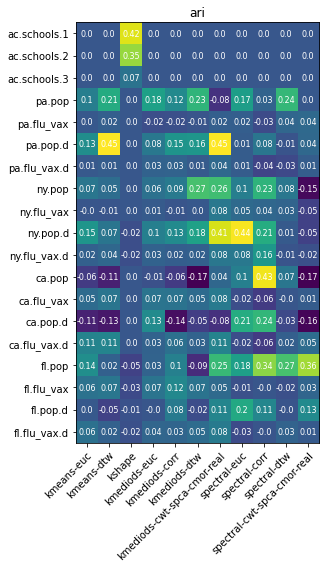

In [22]:
plot_cluster_perf_eval_heatmap(clust_perf_k, 'ari', figsize=(12, 8))

Like with all metrics used in this notebook, higher ARI scores are better (higher scores are represented by lighter shades of yellow).

While simple and effective, we could also use an alternative heatmap which lets us visually group the results for easier interpretation:

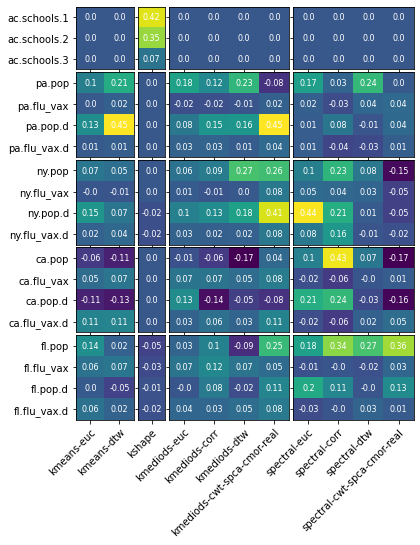

In [23]:
plot_cluster_perf_eval_heatmap_split(clust_perf_k, 'ari', [3,7,11,15], [2,3,7], figsize=(0.5, 0.35))

Finally, we plot the results for a much more "lenient" Fowlkes-Mallows score:

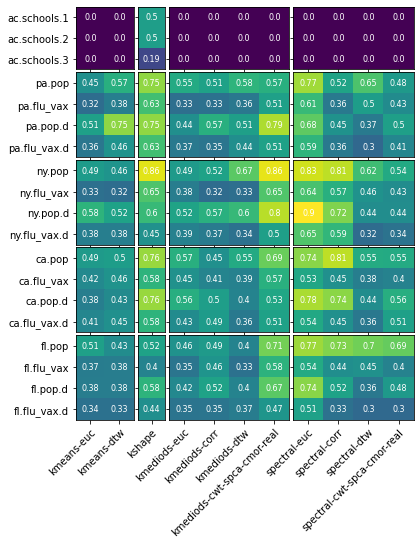

In [24]:
plot_cluster_perf_eval_heatmap_split(clust_perf_k, 'fm', [3,7,11,15], [2,3,7], figsize=(0.5, 0.35))

Well, it's more lenient in theory, because evidently it's pretty harsh on the synthetic dataset (i.e., the first three rows that correspond to the Allegheny County schools data).

### Run experiments: Without the number of clusters

In the exact same order as we have done earlier, the steps to run and visualize the evaluation experiments for clustering algorithms that automatically discover the number of clusters are laid out below:

In [25]:
clust_perf_no_k = {}

In [26]:
clust_perf_no_k.keys()

dict_keys([])

In [27]:
cluster_perf_eval_all_ds(clust_perf_no_k, False, 2077, is_verbose=True)

Dataset                           t
-------------  --------------------
ac.schools.1         0:00:00.393450
ac.schools.2         0:00:00.555014
ac.schools.3         0:00:02.763518
pa.pop               0:01:06.409008
pa.flu_vax           0:01:05.401779
pa.pop.d             0:01:05.041039
pa.flu_vax.d         0:01:04.248710
ny.pop               0:00:58.540578
ny.flu_vax           0:00:58.513146
ny.pop.d             0:00:58.348933
ny.flu_vax.d         0:01:00.471266
ca.pop               0:00:54.391600
ca.flu_vax           0:00:54.634143
ca.pop.d             0:00:54.243637
ca.flu_vax.d         0:00:55.356499
fl.pop               0:01:04.821978
fl.flu_vax           0:01:05.504299
fl.pop.d             0:01:05.594660
fl.flu_vax.d         0:01:05.366185


In [28]:
# del(clust_perf_no_k['ds_ac_schools_0'])

In [29]:
with open(os.path.join('out', 'clust_perf_no_k.pickle'), 'wb') as f:
    pickle.dump(clust_perf_no_k, f, protocol=pickle.HIGHEST_PROTOCOL)

As before, run this to save compute time:

In [30]:
with open(os.path.join('out', 'clust_perf_no_k.pickle'), 'rb') as f:
    clust_perf_no_k = pickle.load(f)

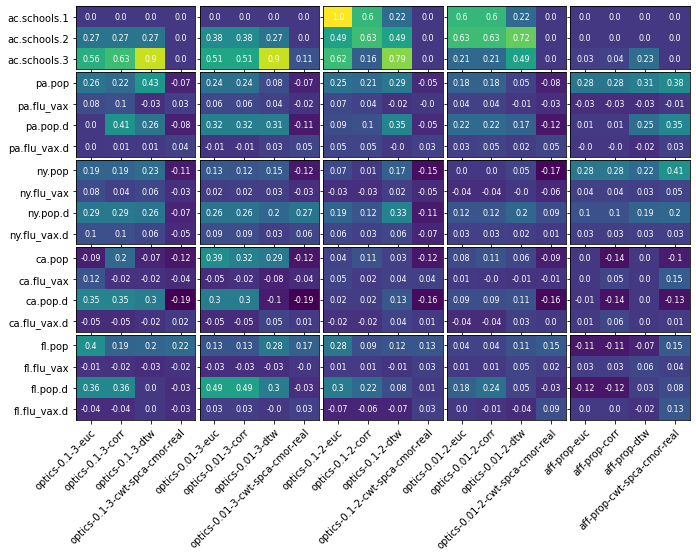

In [31]:
plot_cluster_perf_eval_heatmap_split(clust_perf_no_k, 'ari', [3,7,11,15], [4,8,12,16], figsize=(0.5, 0.35))

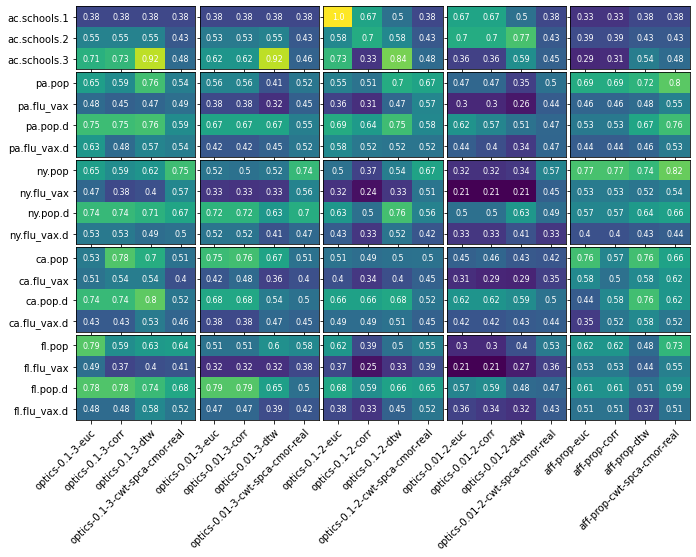

In [32]:
plot_cluster_perf_eval_heatmap_split(clust_perf_no_k, 'fm', [3,7,11,15], [4,8,12,16], figsize=(0.5, 0.35))

We finish with a proper cleanup:

In [33]:
del(ds_ac_schools)
del(ds_pa, ds_ny, ds_ca, ds_fl, ds_pa_d, ds_ny_d, ds_ca_d, ds_fl_d)
del(ds_pa_pop, ds_ny_pop, ds_ca_pop, ds_fl_pop)
del(ds_pa_labels_pop, ds_ny_labels_pop, ds_ca_labels_pop, ds_fl_labels_pop)
del(ds_pa_labels_flu_vax, ds_ny_labels_flu_vax, ds_ca_labels_flu_vax, ds_fl_labels_flu_vax)

del(db)